# Recreation of "200811 Fastq kmer counts basic comparison" with 19AC0011209PEA_S8_L001_R1_001

In [1]:
from pathlib import Path

In [2]:
import numpy as np
import pandas as pd
import h5py as h5
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
%matplotlib inline

In [4]:
from gambit.seq import SequenceFile
from gambit.kmers import KmerSpec, find_kmers
from gambit.sigs import load_signatures
from gambit_pub.fastq import get_phred, phredsum

## Code

In [5]:
# Histogram with transparency fill
def myhist(ax, x, color, alpha=.25, lw=2, **kw):
    h1 = ax.hist(x, fc=color, alpha=alpha, **kw)
    h2 = ax.hist(x, histtype='step', ec=color, lw=lw, **kw)
    return (h1, h2)

## Setup

### Parameters

In [6]:
kspec = KmerSpec(11, 'ATGAC')

In [7]:
phred_thresholds = [10, 15, 20, 25]

### Input files

In [8]:
wf_path = Path('/home/jared/code/gambit/gambit-publication/')

In [9]:
filename = '19AC0011209PEA_S8_L001_R1_001'

In [10]:
fastq_path = wf_path / f'resources/genomes/set3/fastq/{filename}.fastq.gz'
fastq_file = SequenceFile(fastq_path, 'fastq', 'gzip')

fasta_path = wf_path / f'resources/genomes/set3/fasta/{filename}.fasta'
fasta_file = SequenceFile(fasta_path, 'fasta', None)

sigs_path = wf_path / f'intermediate-data/signatures/set3-{kspec.k}-{kspec.prefix_str}.h5'

### Signature

In [12]:
sigs = load_signatures(sigs_path)

In [13]:
(sig_idx,) = np.flatnonzero(sigs.ids == (filename + '.fasta'))

In [14]:
sig = sigs[sig_idx]

## Raw read counts

In [15]:
read_counts = np.zeros((kspec.nkmers, len(phred_thresholds)), dtype=np.int16)
n_invalid = 0

for record in tqdm(fastq_file.parse()):
    phred = get_phred(record)
    
    for match in find_kmers(kspec, record.seq):
        try:
            idx = match.kmer_index()
        except ValueError:
            n_invalid += 1
            continue
            
        phred_agg = phredsum(phred[match.full_indices()])
        phred_bin = np.searchsorted(phred_thresholds, phred_agg, 'right') - 1
        if phred_bin >= 0:
            read_counts[idx, phred_bin] += 1

1424390it [01:01, 23164.41it/s]


In [16]:
read_counts_cum = np.cumsum(read_counts[:, ::-1], axis=1)[:, ::-1]

In [17]:
in_fastq = [np.flatnonzero(read_counts_cum[:, i]) for i in range(4)]

## Assembly counts

In [18]:
assembly_counts = np.zeros(kspec.nkmers, dtype=np.int16)

In [19]:
fasta_ncontigs = 0

for record in fasta_file.parse():
    fasta_ncontigs += 1

    for match in find_kmers(kspec, record.seq):
        assembly_counts[match.kmer_index()] += 1

fasta_ncontigs

4652

In [20]:
np.count_nonzero(assembly_counts)

7001

In [21]:
in_fasta = np.flatnonzero(assembly_counts)
fastq_in_fasta = [np.in1d(in_fastq[i], in_fasta) for i in range(4)]

## Plots

Text(0.5, 0.98, 'Kmer counts in assembly')

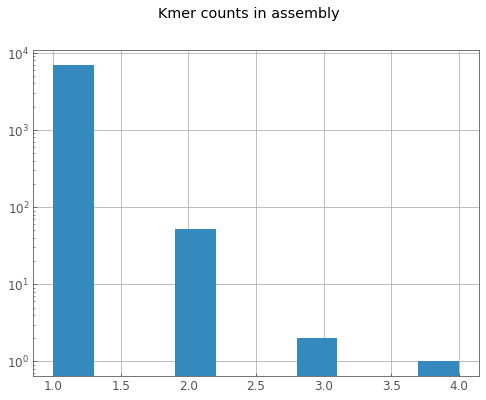

In [22]:
plt.hist(assembly_counts[assembly_counts > 0], bins=10, log=True)
plt.suptitle("Kmer counts in assembly")

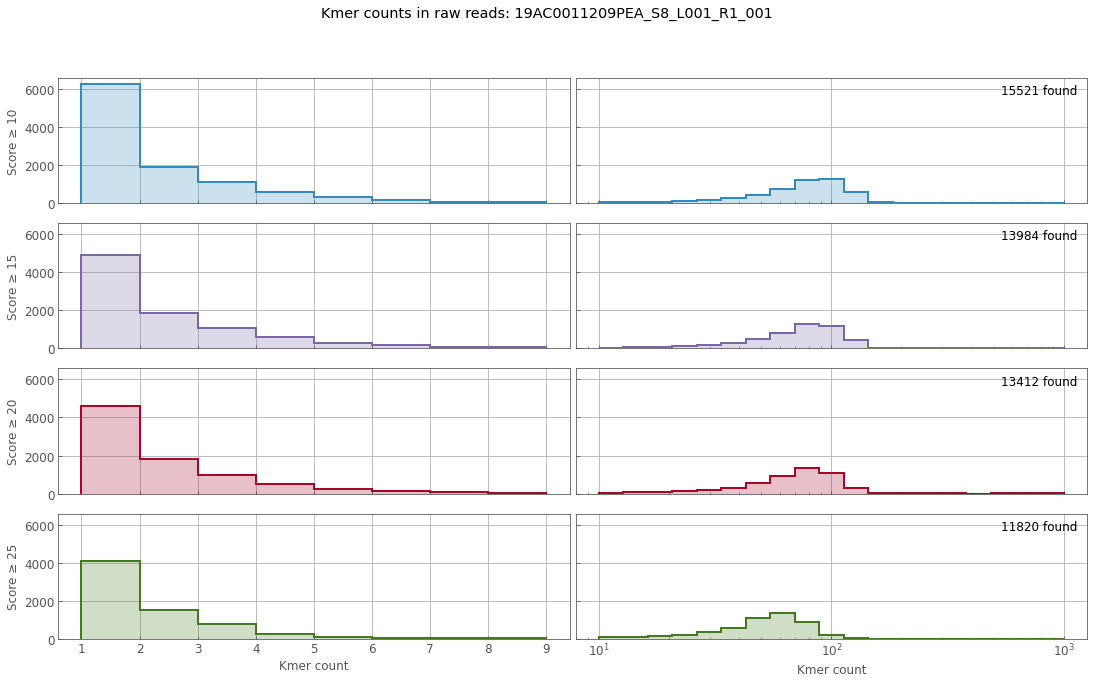

In [23]:
fig, axs = plt.subplots(4, 2, sharex='col', sharey=True, figsize=(16, 10))
pal = sns.color_palette(n_colors=len(phred_thresholds))

bins1 = np.arange(1, 10)
bins2 = 10 ** np.linspace(1, 3, 20)

for (i, t) in enumerate(phred_thresholds):
    ax1, ax2 = axs[i, :]

    vals = read_counts_cum[:, i]
    myhist(ax1, vals, pal[i], bins=bins1)
    myhist(ax2, vals, pal[i], bins=bins2)

    ax1.set_ylabel(f"Score ≥ {t}")

    cnt = np.count_nonzero(read_counts_cum[:, i])
    ax2.text(.98, .95, f"{cnt} found",
        transform=ax2.transAxes, va='top', ha='right')

axs[3, 1].set_xscale('log')
axs[3, 0].set_xlabel("Kmer count")
axs[3, 1].set_xlabel("Kmer count")
plt.suptitle(f"Kmer counts in raw reads: {filename}")
plt.tight_layout(pad=3, w_pad=.5, h_pad=1)

Text(0.5, 0.98, 'Kmer counts in raw reads: 19AC0011209PEA_S8_L001_R1_001')

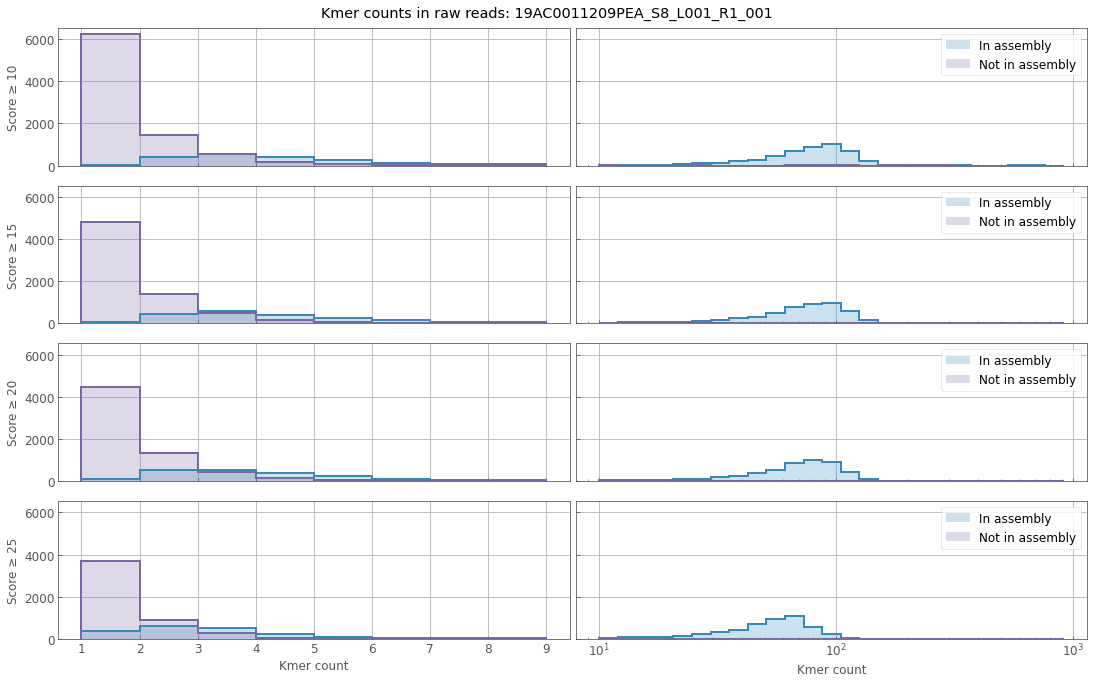

In [24]:
fig, axs = plt.subplots(len(phred_thresholds), 2, sharex='col', sharey=True, figsize=(16, 10))

max_read = np.max(read_counts_cum)
nbins = 25
bins1 = np.arange(1, 10)
bins2 = 10 ** np.linspace(1, np.log10(max_read+1), nbins+1)

pal = sns.color_palette(n_colors=2)
alpha = 0.25

for i, thresh in enumerate(phred_thresholds):
    ax1, ax2 = axs[i, :]
    read_counts2 = read_counts_cum[in_fastq[i], i]
    max_read = np.max(read_counts2)

    ax2.set_xscale('log')
    ax1.set_ylabel(f"Score ≥ {thresh}")

    for (ax, bins) in zip([ax1, ax2], [bins1, bins2]):
        h1 = myhist(ax, 
            read_counts2[fastq_in_fasta[i]],
            pal[0],
            bins=bins)
        h2 = myhist(ax, 
            read_counts2[~fastq_in_fasta[i]],
            pal[1],
            bins=bins)
    
    ax2.legend([h1[0][2][0], h2[0][2][0]], ["In assembly", "Not in assembly"])

axs[3, 0].set_xlabel("Kmer count")
axs[3, 1].set_xlabel("Kmer count")

fig.tight_layout(pad=3, w_pad=.5, h_pad=1)
plt.suptitle(f"Kmer counts in raw reads: {filename}")

## Accuracy

In [25]:
count_thresholds = [*range(1, 6), 10]

In [26]:
rows = []

for (i, score_thresh) in enumerate(phred_thresholds):
    _fastq_counts = read_counts_cum[in_fastq[i], i]
    for count_thresh in count_thresholds:
        
        _fastq_over = _fastq_counts >= count_thresh
        _c_fastq_fasta = np.sum(_fastq_over[fastq_in_fasta[i]])
        _c_fastq_only = np.sum(_fastq_over[~fastq_in_fasta[i]])
        _c_fasta_only = len(in_fasta) - _c_fastq_fasta
        _c_none = kspec.nkmers - _c_fastq_fasta - _c_fastq_only - _c_fasta_only
        
        rows.append((score_thresh, count_thresh, True, True, _c_fastq_fasta))
        rows.append((score_thresh, count_thresh, True, False, _c_fastq_only))
        rows.append((score_thresh, count_thresh, False, True, _c_fasta_only))
        rows.append((score_thresh, count_thresh, False, False, _c_none))

cols = ['score_threshold', 'count_threshold', 'in_reads', 'in_assembly', 'count']
counts_df = pd.DataFrame.from_records(rows, columns=cols).set_index(cols[:-1])
counts_df.sort_index(inplace=True)

In [27]:
assert all(counts_df.groupby(['score_threshold', 'count_threshold'])['count'].sum() == kspec.nkmers)

In [28]:
counts_df

count
score_threshold count_threshold in_reads in_assembly         
10              1               False    False        4178743
                                         True              40
                                True     False           8560
                                         True            6961
                2               False    False        4184979
...                                                       ...
25              5               True     True            5156
                10              False    False        4187272
                                         True            2058
                                True     False             31
                                         True            4943

[96 rows x 1 columns]

In [29]:
rows = []
kmer_in_assembly = assembly_counts >= 1

for (i, score_thresh) in enumerate(phred_thresholds):
    for count_thresh in count_thresholds:
        kmer_in_read = read_counts[:, i] >= count_thresh
        for in_read in [False, True]:
            for in_assembly in [False, True]:
                c = np.sum((kmer_in_read == in_read) & (kmer_in_assembly == in_assembly))
                rows.append((score_thresh, count_thresh, in_read, in_assembly, c))

cols = ['score_threshold', 'count_threshold', 'in_reads', 'in_assembly', 'count']
counts_df2 = pd.DataFrame.from_records(rows, columns=cols).set_index(cols[:-1])
counts_df2.sort_index(inplace=True)

In [30]:
assert all(counts_df2.groupby(['score_threshold', 'count_threshold'])['count'].sum() == kspec.nkmers)

In [31]:
rows = []
keys = []

for key, g in counts_df.groupby(['score_threshold', 'count_threshold']):
    g = g['count'].reset_index(['score_threshold', 'count_threshold'], drop=True)
    tp = g.loc[True, True]
    fp = g.loc[True, False]
    fn = g.loc[False, True]
    rows.append([tp / (tp + fp), tp / (tp + fn), 1 - tp / (tp + fn + fp)])
    keys.append(key)
    
pr_df = pd.DataFrame.from_records(
    rows,
    columns=['precision', 'recall', 'jaccard'],
    index=pd.MultiIndex.from_tuples(keys, names=['score_threshold', 'count_threshold']),
)

In [32]:
pr_df

precision    recall   jaccard
score_threshold count_threshold                               
10              1                 0.448489  0.994287  0.552664
                2                 0.748675  0.988859  0.257587
                3                 0.882745  0.928010  0.173830
                4                 0.951145  0.848165  0.187243
                5                 0.978238  0.789744  0.223891
                10                0.993439  0.713755  0.289593
15              1                 0.497712  0.994144  0.503743
                2                 0.757969  0.985002  0.250679
                3                 0.889823  0.921725  0.172692
                4                 0.953191  0.840594  0.192730
                5                 0.980189  0.784459  0.227784
                10                0.993434  0.713184  0.290162
20              1                 0.517820  0.992001  0.484333
                2                 0.775269  0.976146  0.239145
                3                 0.903499  0.900014  0.178916
                4                 0.961871  0.825168  0.200968
                5                 0.983786  0.771318  0.238364
                10                0.993432  0.712898  0.290446
25              1                 0.580711  0.980431  0.425943
                2                 0.836345  0.925582  0.216350
                3                 0.942687  0.838737  0.201957
                4                 0.980478  0.767605  0.243950
                5                 0.989825  0.736466  0.269067
                10                0.993768  0.706042  0.297071

In [33]:
pr_df.iloc[np.argmin(pr_df['jaccard'])]

precision    0.889823
recall       0.921725
jaccard      0.172692
Name: (15, 3), dtype: float64